<a href="https://colab.research.google.com/github/buraktango/2018-05-30-KRSCourseInBiomedicalImageAnalysisAndVisualization/blob/master/Sperm_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Workspace

In [0]:
cd drive/My\ Drive/Sperm_Classification

/content/drive/My Drive/Sperm_Classification


# Reading Images

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import remove_background

text_file = open("SCIAN-MorphoSpermGS/PA-expert-annotations.txt", 'r')

In [0]:
# Reading the text file
lines = []
for line in text_file.readlines():
  lines.append(line)

**Separate the Images to their respective Class**

In [0]:
label_encoding = {0:"Normal",1:"Tapered",2:"Pyriform",3:"Small",5:"Amorphous"}

In [0]:
from google.colab.patches import cv2_imshow
dataset_folder = "DataSet"
folder_path = "SCIAN-MorphoSpermGS/Partial-Agreement-Images"

for line in lines:
  # p, pl, sample and sperm no.
  x = line.split('-')
  px = int(x[0][1:])
  plx = int(x[1][2:])
  samplex = int(x[2].split('/')[0][6:])
  spermx  = int(x[2].split('/')[1].split('\t')[0][6:])

  # Annotation 
  label = int(line.split('\t')[-1].split('\n')[0])

  img_file = f"ch00_p{px}-pl{plx}-sample{samplex}-sperm{spermx}.tif"

  img_path = os.path.join(folder_path, img_file)

  img = remove_background.remove_bg(img_path)

  class_folder = os.path.join(dataset_folder, label_encoding[label])
  img_file_write = f"ch00_p{px}-pl{plx}-sample{samplex}-sperm{spermx}.png"
  img_write_path = os.path.join(class_folder, img_file_write)

  cv2.imwrite(img_write_path, img)

  print(f"Writing: {img_file}")


No of Samples per Class

In [0]:
dataset_folder = "DataSet"
counts = {}
for folder in os.listdir(dataset_folder):
  counts[folder] = len(os.listdir(os.path.join(dataset_folder, folder)))
  print(folder, len(os.listdir(os.path.join(dataset_folder, folder))))

Amorphous 656
Normal 100
Small 72
Pyriform 76
Tapered 228


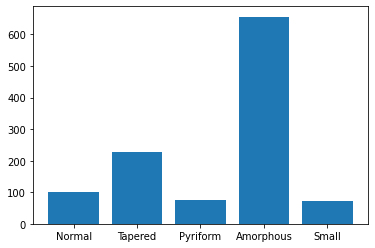

In [0]:
classes = counts.keys()
values = counts.values()

plt.bar(classes, values)
#plt.savefig("plt.png")
plt.show()


# Building the Model

**Trainig with Custom Model**

In [0]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


def createCustomModel(input_shape, nClasses):

  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=nClasses, activation="sigmoid"))

  return model




**Train Test Split** 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def splitData(dataFolder, shape, batch_size):

  data_dir = dataFolder
  img_height = shape[0]
  img_width = shape[1]

  train_datagen = ImageDataGenerator(rescale=1./255,
      # shear_range=0.2,
      # zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      validation_split=0.2) # set validation split

  train_generator = train_datagen.flow_from_directory(
      data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='training') # set as training data

  validation_generator = train_datagen.flow_from_directory(
      data_dir, 
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation') # set as validation data

  return train_generator, validation_generator

**Compiling The Model**

In [0]:
from keras.optimizers import SGD
def compiling(model):
  opt = SGD(lr=0.01, momentum=0.9, decay=0.01)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

**Training The Model**

In [0]:
def training(model, train_generator, validation_generator, epoch, batch_size):
  nb_epochs = epoch

  model.fit_generator(
      train_generator,
      #steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      #validation_steps = validation_generator.samples // batch_size,
      use_multiprocessing=True,
      epochs = nb_epochs)
  
  return model

In [0]:

def trainDataFolder(dataFolder, nClasses, shape, epoch, batch_size):
  input_shape = (shape[0], shape[1], shape[2])

  model = createCustomModel(input_shape, nClasses)
  train_generator, validation_generator = splitData(dataFolder, shape, batch_size)
  compiling(model)
  print("Done")
  history = training(model, train_generator, validation_generator, epoch, batch_size)

  return model, history


In [0]:
model, history = trainDataFolder('DataSet', 5, (224,224,3), 10, 32)

**Trainig with VGG and Xception Network**

In [0]:
####### Using Xception prtrained model #########
import keras
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
import numpy as np


def createCustomModel(input_shape, nClasses):
  #Get back the convolutional part of a VGG network trained on ImageNet
  model_vgg16_conv = Xception(weights='imagenet', include_top=False)
  model_vgg16_conv.summary()

  #Create your own input format (here 3x200x200)
  input = Input(shape=input_shape,name = 'image_input')

  #Use the generated model 
  output_vgg16_conv = model_vgg16_conv(input)

  #Add the fully-connected layers 
  x = Flatten(name='flatten')(output_vgg16_conv)
  x = Dense(1024, activation='relu', name='fc1')(x)
  x = Dropout(0.4)(x)
  x = Dense(nClasses, activation='softmax', name='predictions')(x)

  #Create your own model 
  my_model = Model(input=input, output=x)

  opt = SGD(lr=0.01, momentum=0.9, decay=0.01)

  #In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
  #my_model.summary()
  my_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return my_model

In [0]:

def trainXceptionModel(dataFolder, nClasses, shape, epoch, batch_size):
  input_shape = (shape[0], shape[1], shape[2])

  model = createCustomModel(input_shape, nClasses)
  train_generator, validation_generator = splitData(dataFolder, shape, batch_size)
  
  history = training(model, train_generator, validation_generator, epoch, batch_size)

  return model, history


In [0]:
model, history = trainXceptionModel('DataSet', 5, (224,224,3), 10, 32)

**Manual Reading of the Data**

In [0]:
import cv2
# DataSet reading
label_encoding = {0:"Normal",0:"Tapered",0:"Pyriform",0:"Small",1:"Amorphous"}
label_decoding = {"Normal":0,"Tapered":0,"Pyriform":0,"Small":0,"Amorphous":1}

data_folder = 'DataSet'
Xtrain = []
Ytrain = []

Xtest = []
Ytest = []

for folder in os.listdir(data_folder):
  print(f"Reading {folder}")
  folder_path = os.path.join(data_folder, folder)
  folder_images = os.listdir(folder_path)

  folder_len = len(folder_images)
  train_len = int(len(folder_images)*0.8)

  # Collect Train images
  for i in range(train_len):
    img_file = os.path.join(folder_path, folder_images[i])
    img = cv2.imread(img_file,0)

    #print(img_file)
    Xtrain.append(img)
    Ytrain.append(label_decoding[str(folder)])

  
  # Collect Test images
  for i in range(train_len, folder_len):
    img_file = os.path.join(folder_path, folder_images[i])
    img = cv2.imread(img_file,0)

    Xtest.append(img)
    Ytest.append(label_decoding[str(folder)])


Reading Amorphous
Reading Normal
Reading Small
Reading Pyriform
Reading Tapered


In [0]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

Xtest = np.array(Xtest)
Ytest = np.array(Ytest)

Xtrain = np.expand_dims(Xtrain, axis=3)
Xtest = np.expand_dims(Xtest, axis=3)

(903, 224, 224, 1)


In [0]:
from keras.utils import to_categorical
#Convert to Categorical
n_classes = 5

Ytrain = to_categorical(Ytrain, num_classes=n_classes)
Ytest = to_categorical(Ytest, num_classes=n_classes)

Using TensorFlow backend.


In [0]:
my_model.fit(x=Xtrain, y=Ytrain, batch_size=16, epochs=10, validation_data=(Xtest, Ytest), use_multiprocessing=True)